In [5]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

from wofscast import icosahedral_mesh, model_utils, square_mesh
from wofscast import grid_mesh_connectivity 
from wofscast.square_mesh import _ChildVerticesBuilder, TriangularMesh

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from glob import glob

In [6]:
dataset = xr.load_dataset(glob('/work/mflora/wofs-cast-data/datasets/dataset*')[0])

## Creating a heirarchial structured mesh on a square domain

In [14]:
# Specification of the multimesh.
mesh_size=3
N=50
meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=N))

finest_mesh = meshes[-1]
grid_lat = dataset['lat'].values
grid_lon = dataset['lon'].values

mesh_nodes_lon, mesh_nodes_lat = square_mesh.get_mesh_coords(finest_mesh, grid_lat, grid_lon)

In [23]:
def _get_max_edge_distance(mesh):
  senders, receivers = square_mesh.faces_to_edges(mesh.faces)
  edge_distances = np.linalg.norm(
      mesh.vertices[senders] - mesh.vertices[receivers], axis=-1)
  return edge_distances.max()


print(_get_max_edge_distance(meshes[-1]))

6.0


12.041594578792296


Text(0.5, 1.0, 'Example Mesh')

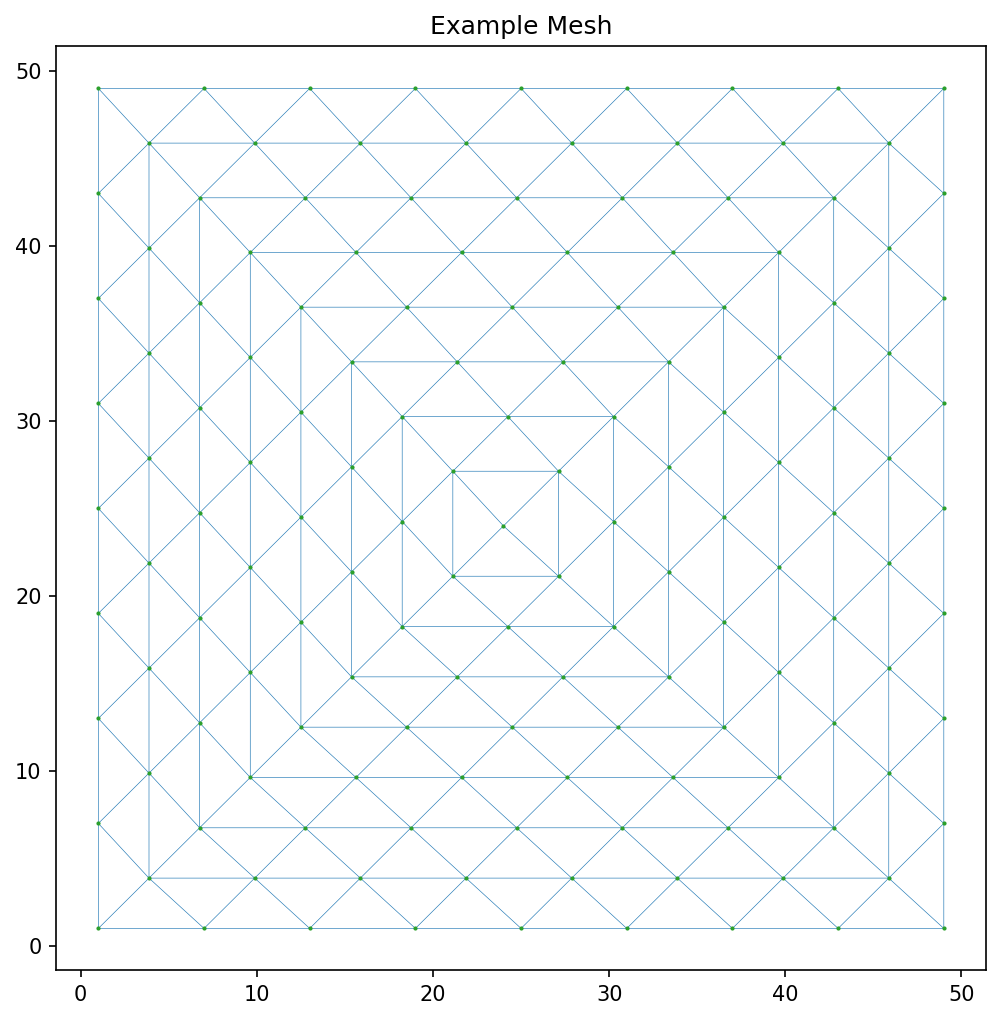

In [15]:
import math

fig, ax = plt.subplots(dpi=150, figsize=(8,8))

mesh = meshes[-1]

# Step 4: Create the Mesh Data Structure
vertices = mesh.vertices  # The vertices are just the points on the grid
faces = mesh.faces  # The faces are defined by the Delaunay triangulation

print(math.sqrt(len(vertices[:,0])))

# Visualize the Mesh
ax.triplot(vertices[:, 0], vertices[:, 1], faces, markersize=0.01, lw=0.3)
ax.plot(vertices[:, 0], vertices[:, 1], 'o', markersize=1,)  # plot the vertices
ax.set_title('Example Mesh')
#ax.set_xticks(range(0,N+1))
#ax.set_yticks(range(0,N+1))
#ax.grid(ls='dashed')


## Connecting grid points to the Mesh nodes

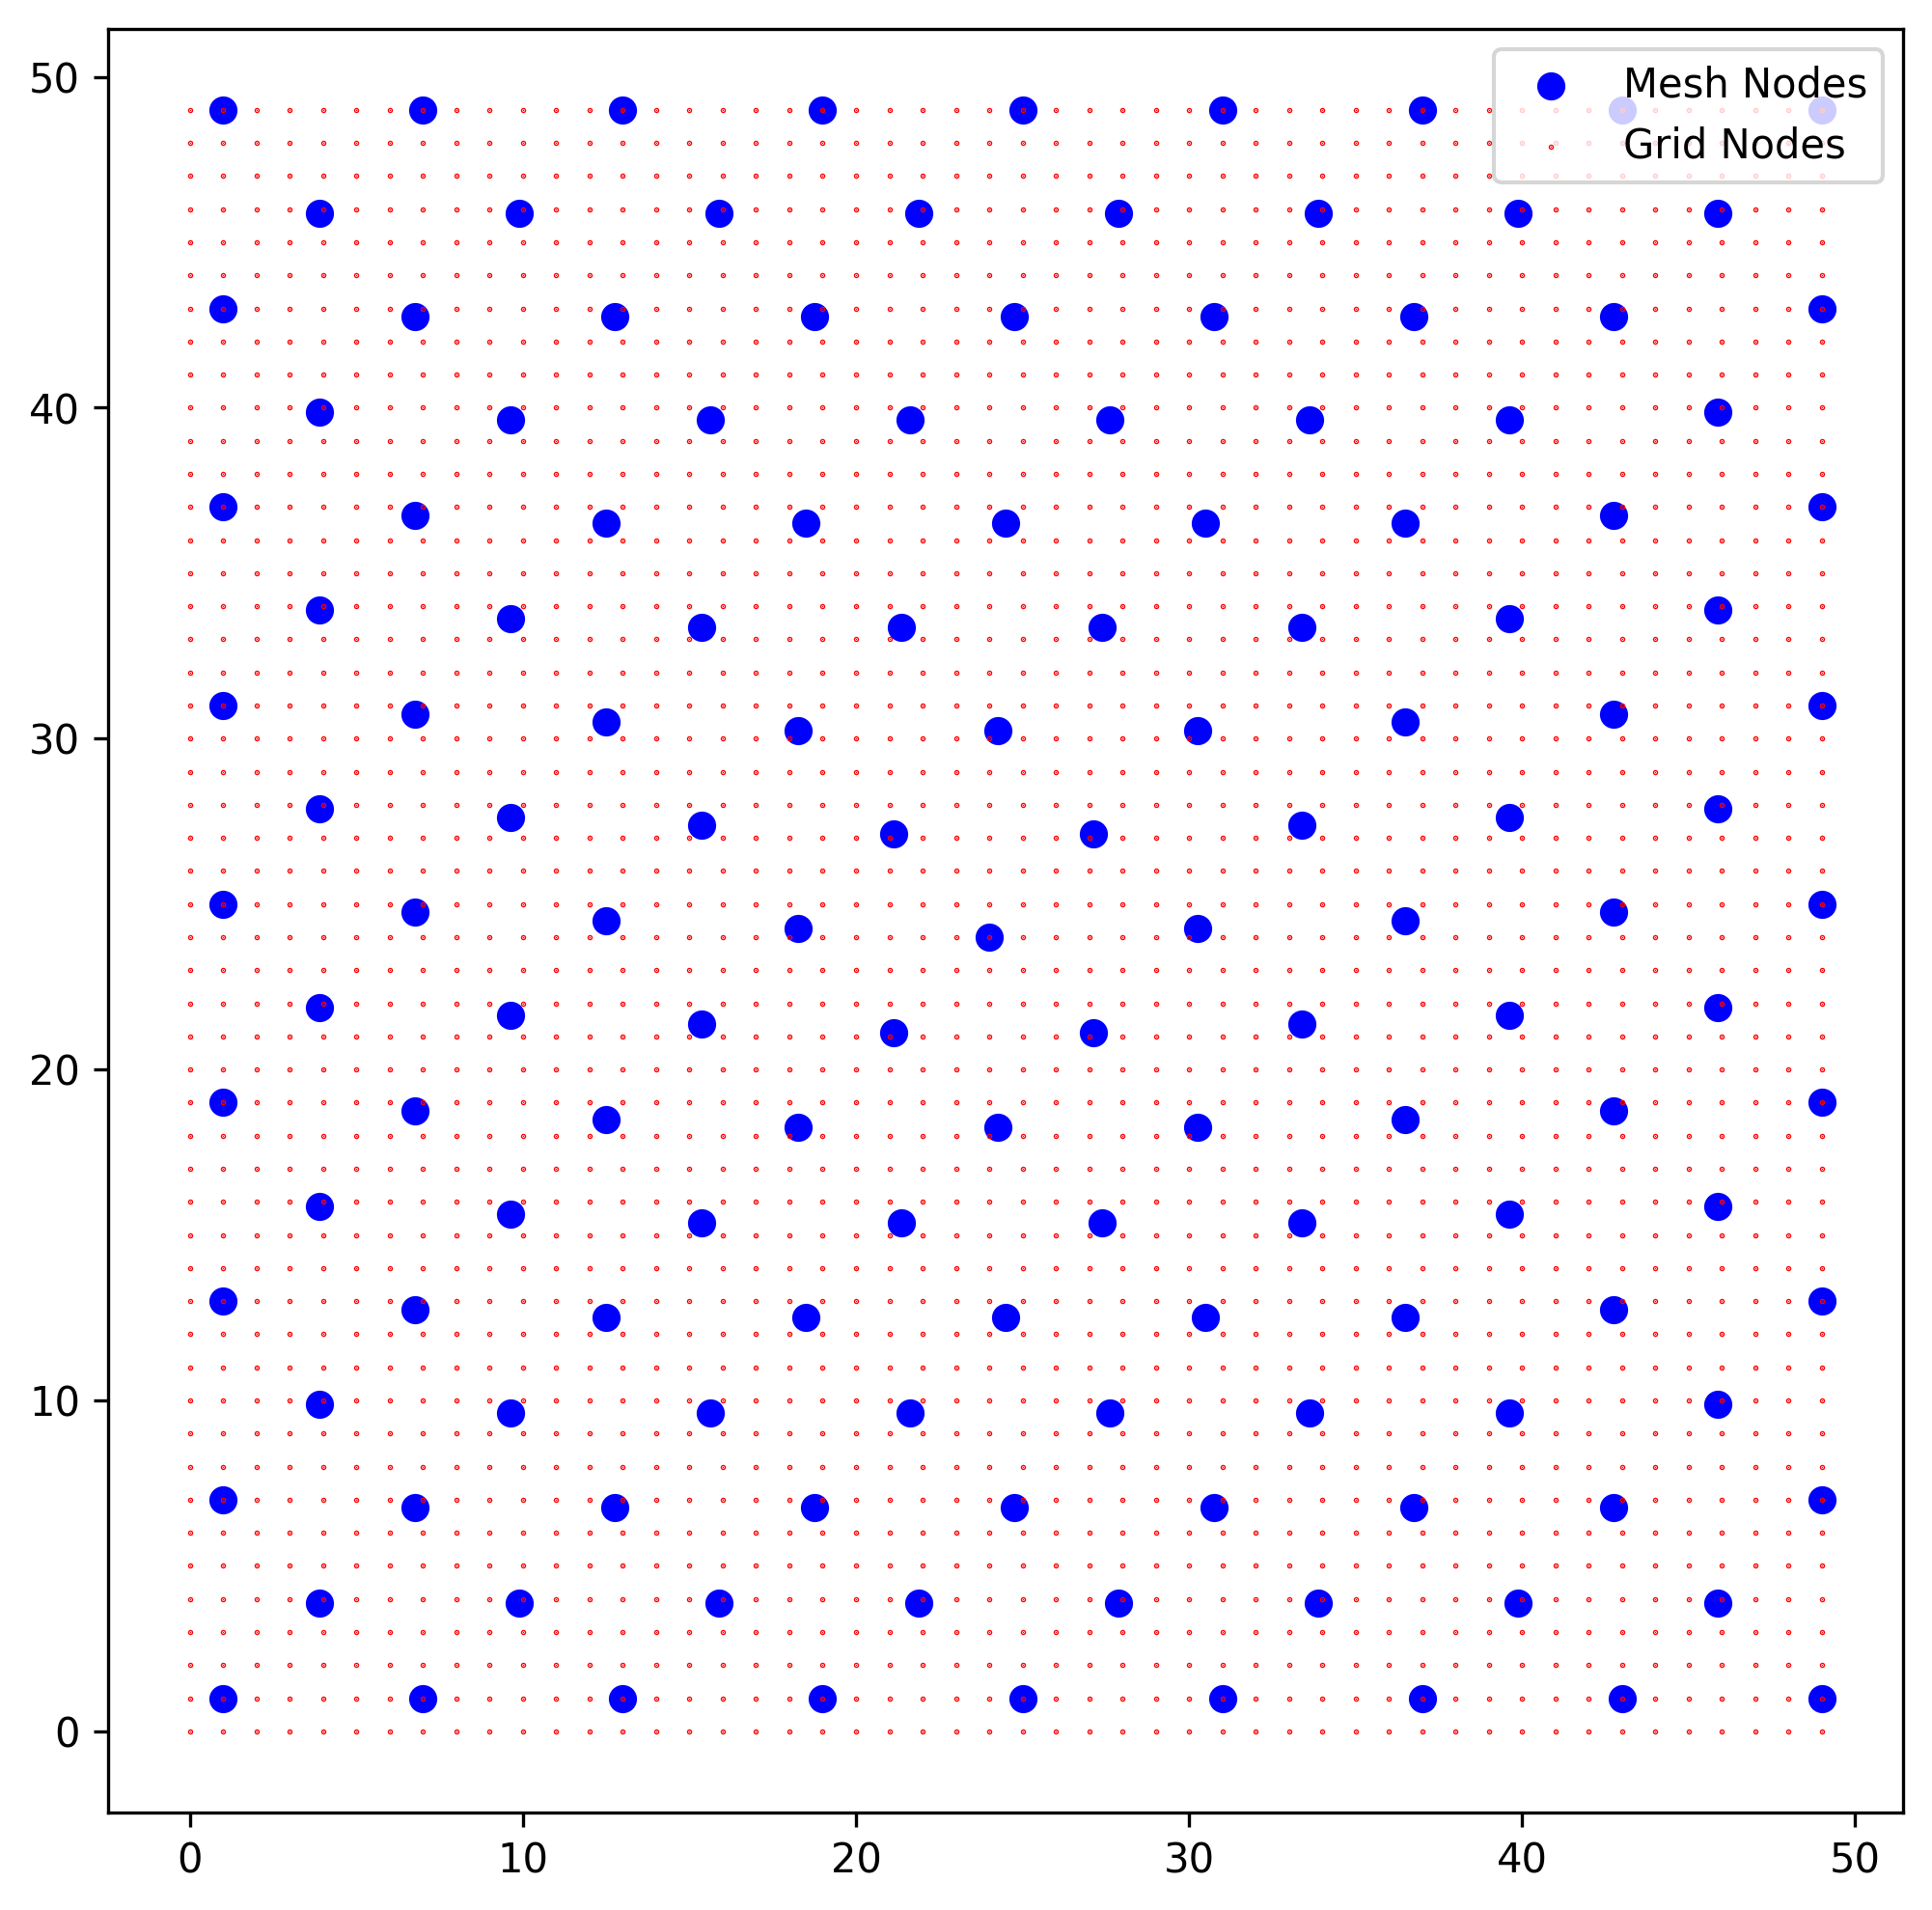

In [16]:
# Convert latitudes and longitudes to Cartesian coordinates
grid_positions = square_mesh.get_grid_positions(N)
mesh_positions = meshes[-1].vertices
  

# Plot mesh vertices
fig, ax = plt.subplots(dpi=300, figsize=(8,8))
ax.scatter(mesh_positions[:, 0], mesh_positions[:, 1], color='blue', label='Mesh Nodes')
ax.scatter(grid_positions[:, 0], grid_positions[:, 1], color='red', s=0.1, label='Grid Nodes')
ax.legend()

In [19]:
# Radius is interpreted in the 3 km grid spacing distance. 
grid_indices, mesh_indices = square_mesh.radius_query_indices(50, finest_mesh, radius=2)

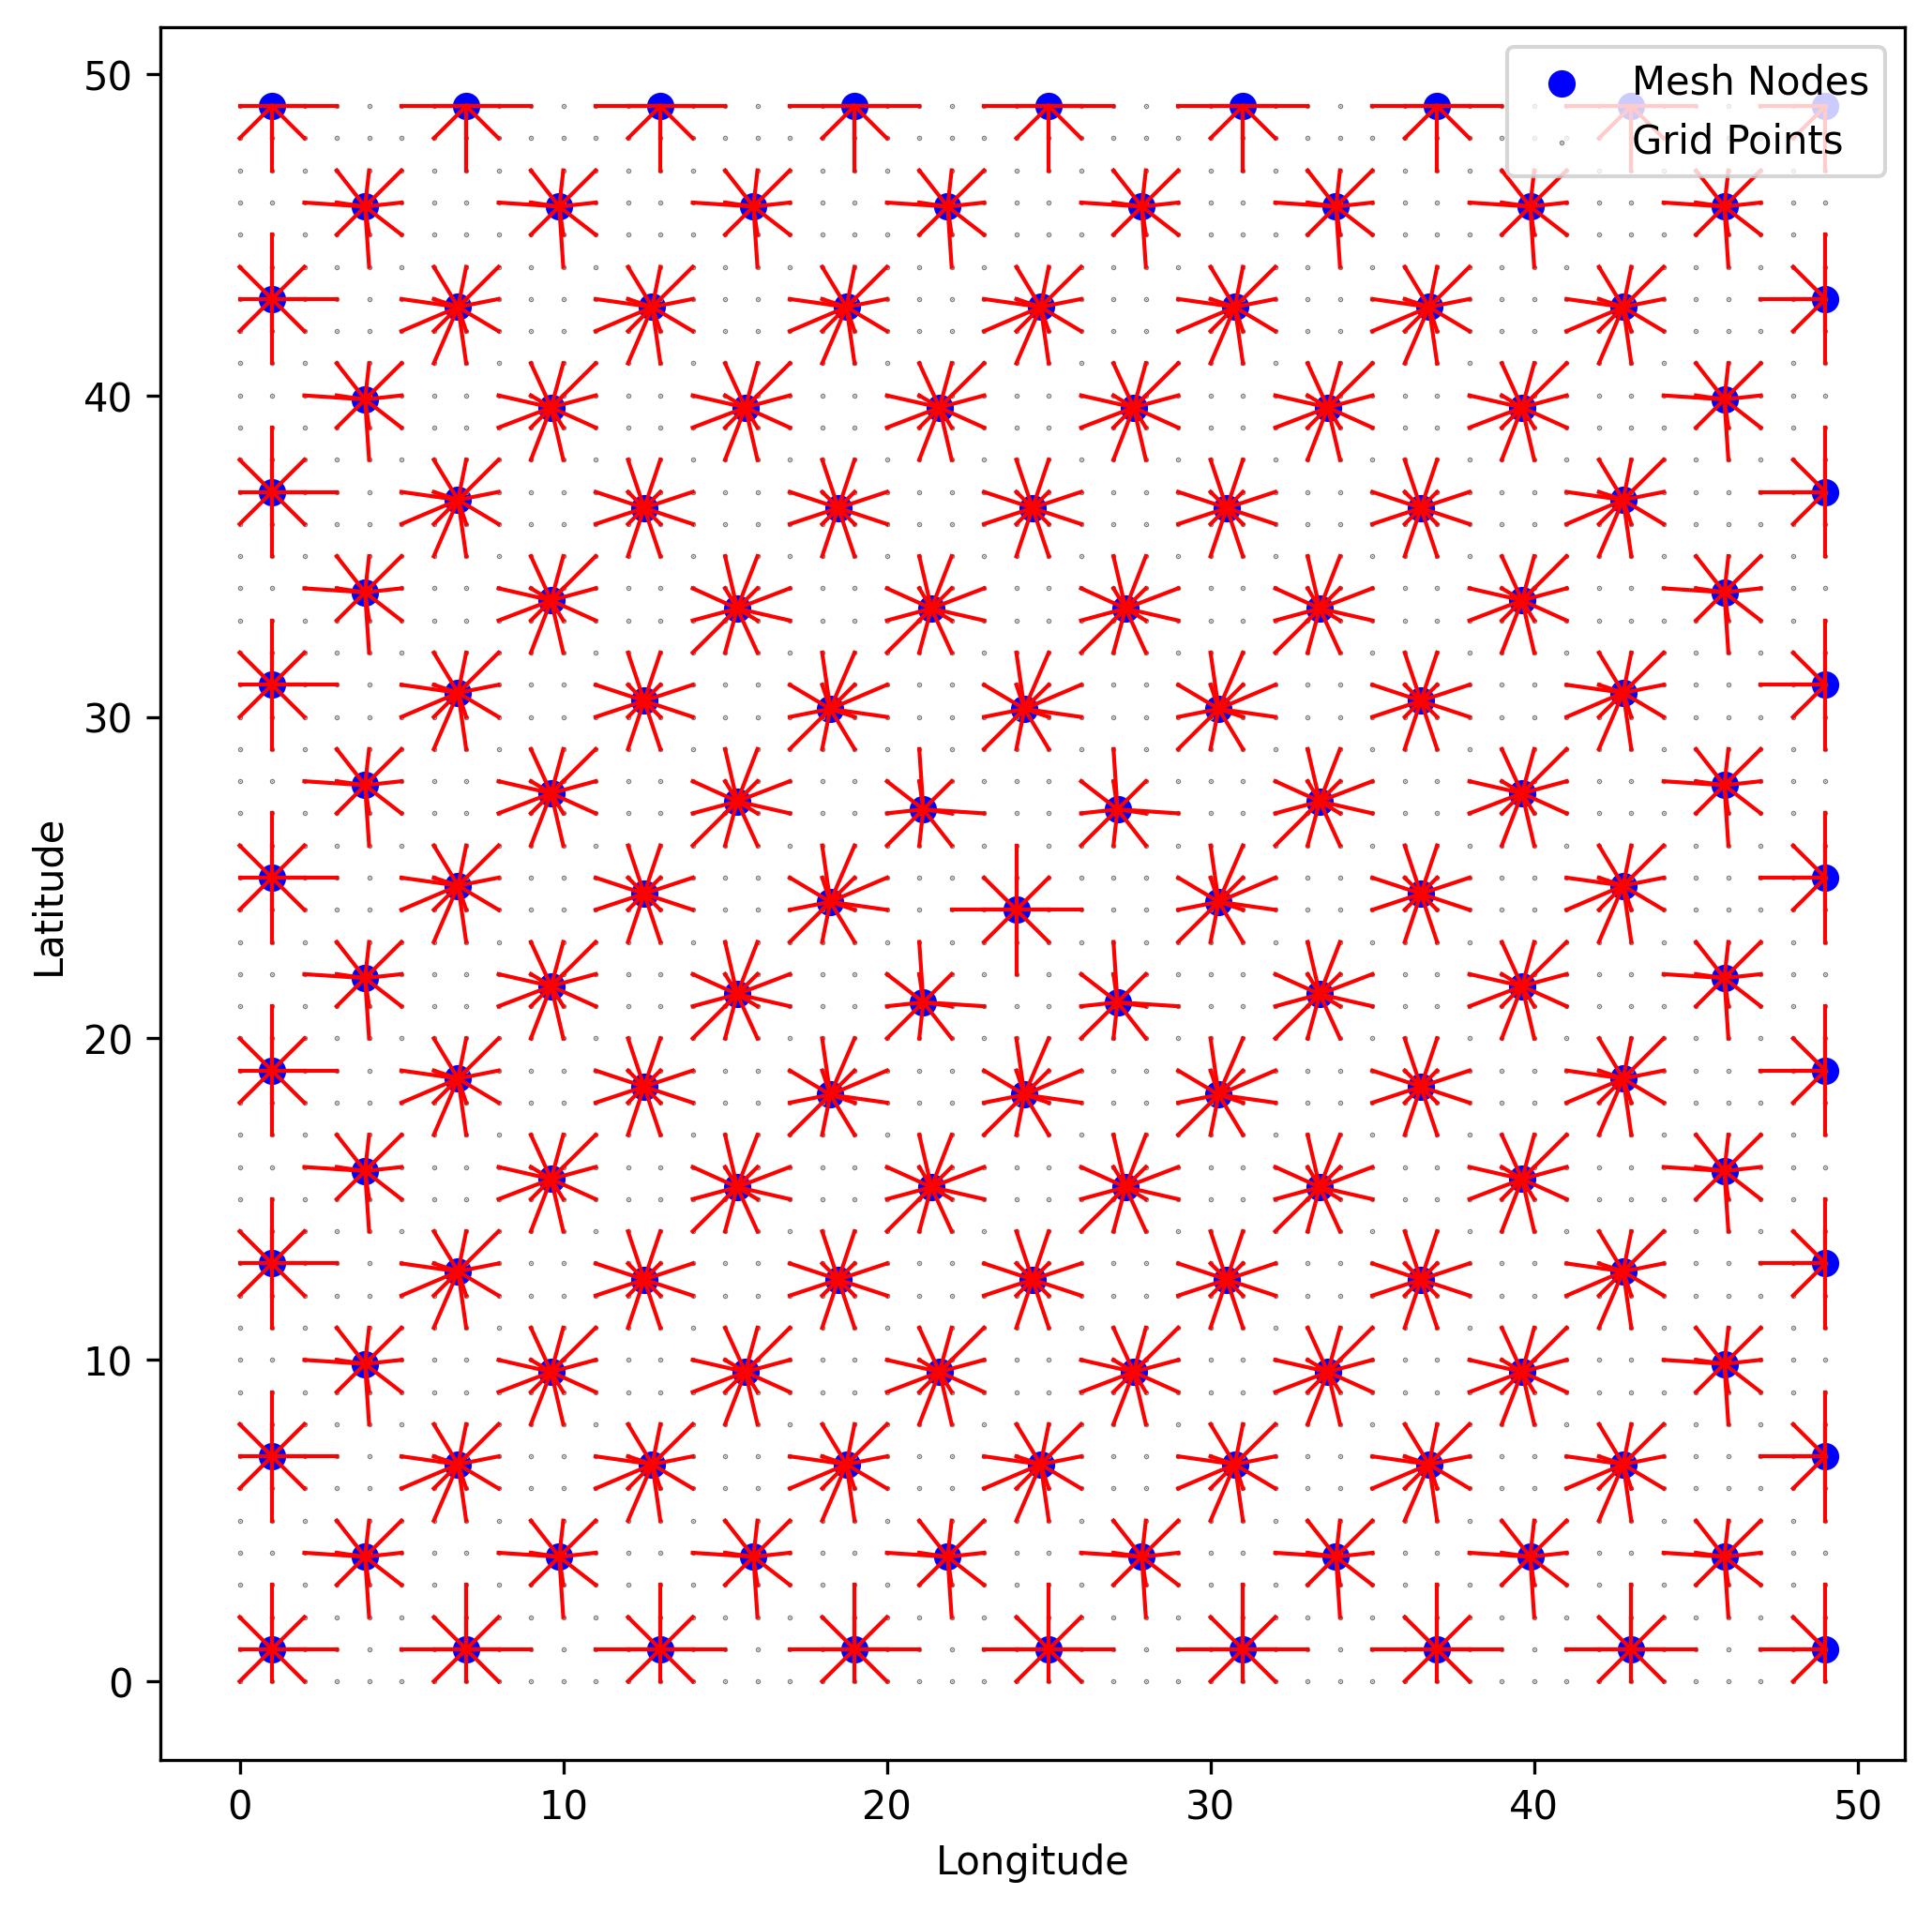

In [20]:
# Plot how the grid nodes connect to a single mesh node.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_connectivity(grid_size, mesh, grid_indices, mesh_indices):
    fig, ax = plt.subplots(dpi=300, figsize=(8,8))

    # Plot mesh vertices
    ax.scatter(mesh.vertices[:, 0], mesh.vertices[:, 1], color='blue', label='Mesh Nodes')

    # Generate grid points and plot
    lon, lat = np.meshgrid(np.arange(0,grid_size), np.arange(0,grid_size))

    ax.scatter(lon.flatten(), lat.flatten(), color='gray', s=0.1, label='Grid Points')

    # Highlight connections
    for g_idx, m_idx in zip(grid_indices, mesh_indices):
        grid_point = [lon.flatten()[g_idx], lat.flatten()[g_idx]]
        mesh_node = mesh.vertices[m_idx]
        ax.plot([grid_point[0], mesh_node[0]], [grid_point[1], mesh_node[1]], 'r-',lw=1)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    
    #ax.set(xlim=(0,25), ylim=(0,25))
    
    plt.show()
    
plot_connectivity(N, finest_mesh, grid_indices, mesh_indices)

## Creating the edge features between grid and mesh

In [21]:
spatial_features_kwargs = dict(
        add_node_positions=False,
        add_node_latitude=True,
        add_node_longitude=True,
        add_relative_positions=True,
        relative_longitude_local_coordinates=True,
        relative_latitude_local_coordinates=True,
    )

# Edges sending info from grid to mesh.
senders = grid_indices
receivers = mesh_indices

# Initialize lat and lon for the grid.
grid_nodes_lon, grid_nodes_lat = np.meshgrid(grid_lon, grid_lat)
grid_nodes_lon = grid_nodes_lon.reshape([-1]).astype(np.float32)
grid_nodes_lat = grid_nodes_lat.reshape([-1]).astype(np.float32)

# Precompute structural node and edge features according to config options.
# Structural features are those that depend on the fixed values of the
# latitude and longitudes of the nodes.
(senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=grid_nodes_lat,
         senders_node_lon=grid_nodes_lon,
         receivers_node_lat=mesh_nodes_lat,
         receivers_node_lon=mesh_nodes_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=None,
         **spatial_features_kwargs,
     )

## Connecting the Mesh nodes back to the grid points

In [17]:
# Create some edges according to how the grid nodes are contained by
# mesh triangles.
(these_grid_indices,
     these_mesh_indices) = square_mesh.in_mesh_triangle_indices(
         grid_size=N,
         mesh=meshes[-1])

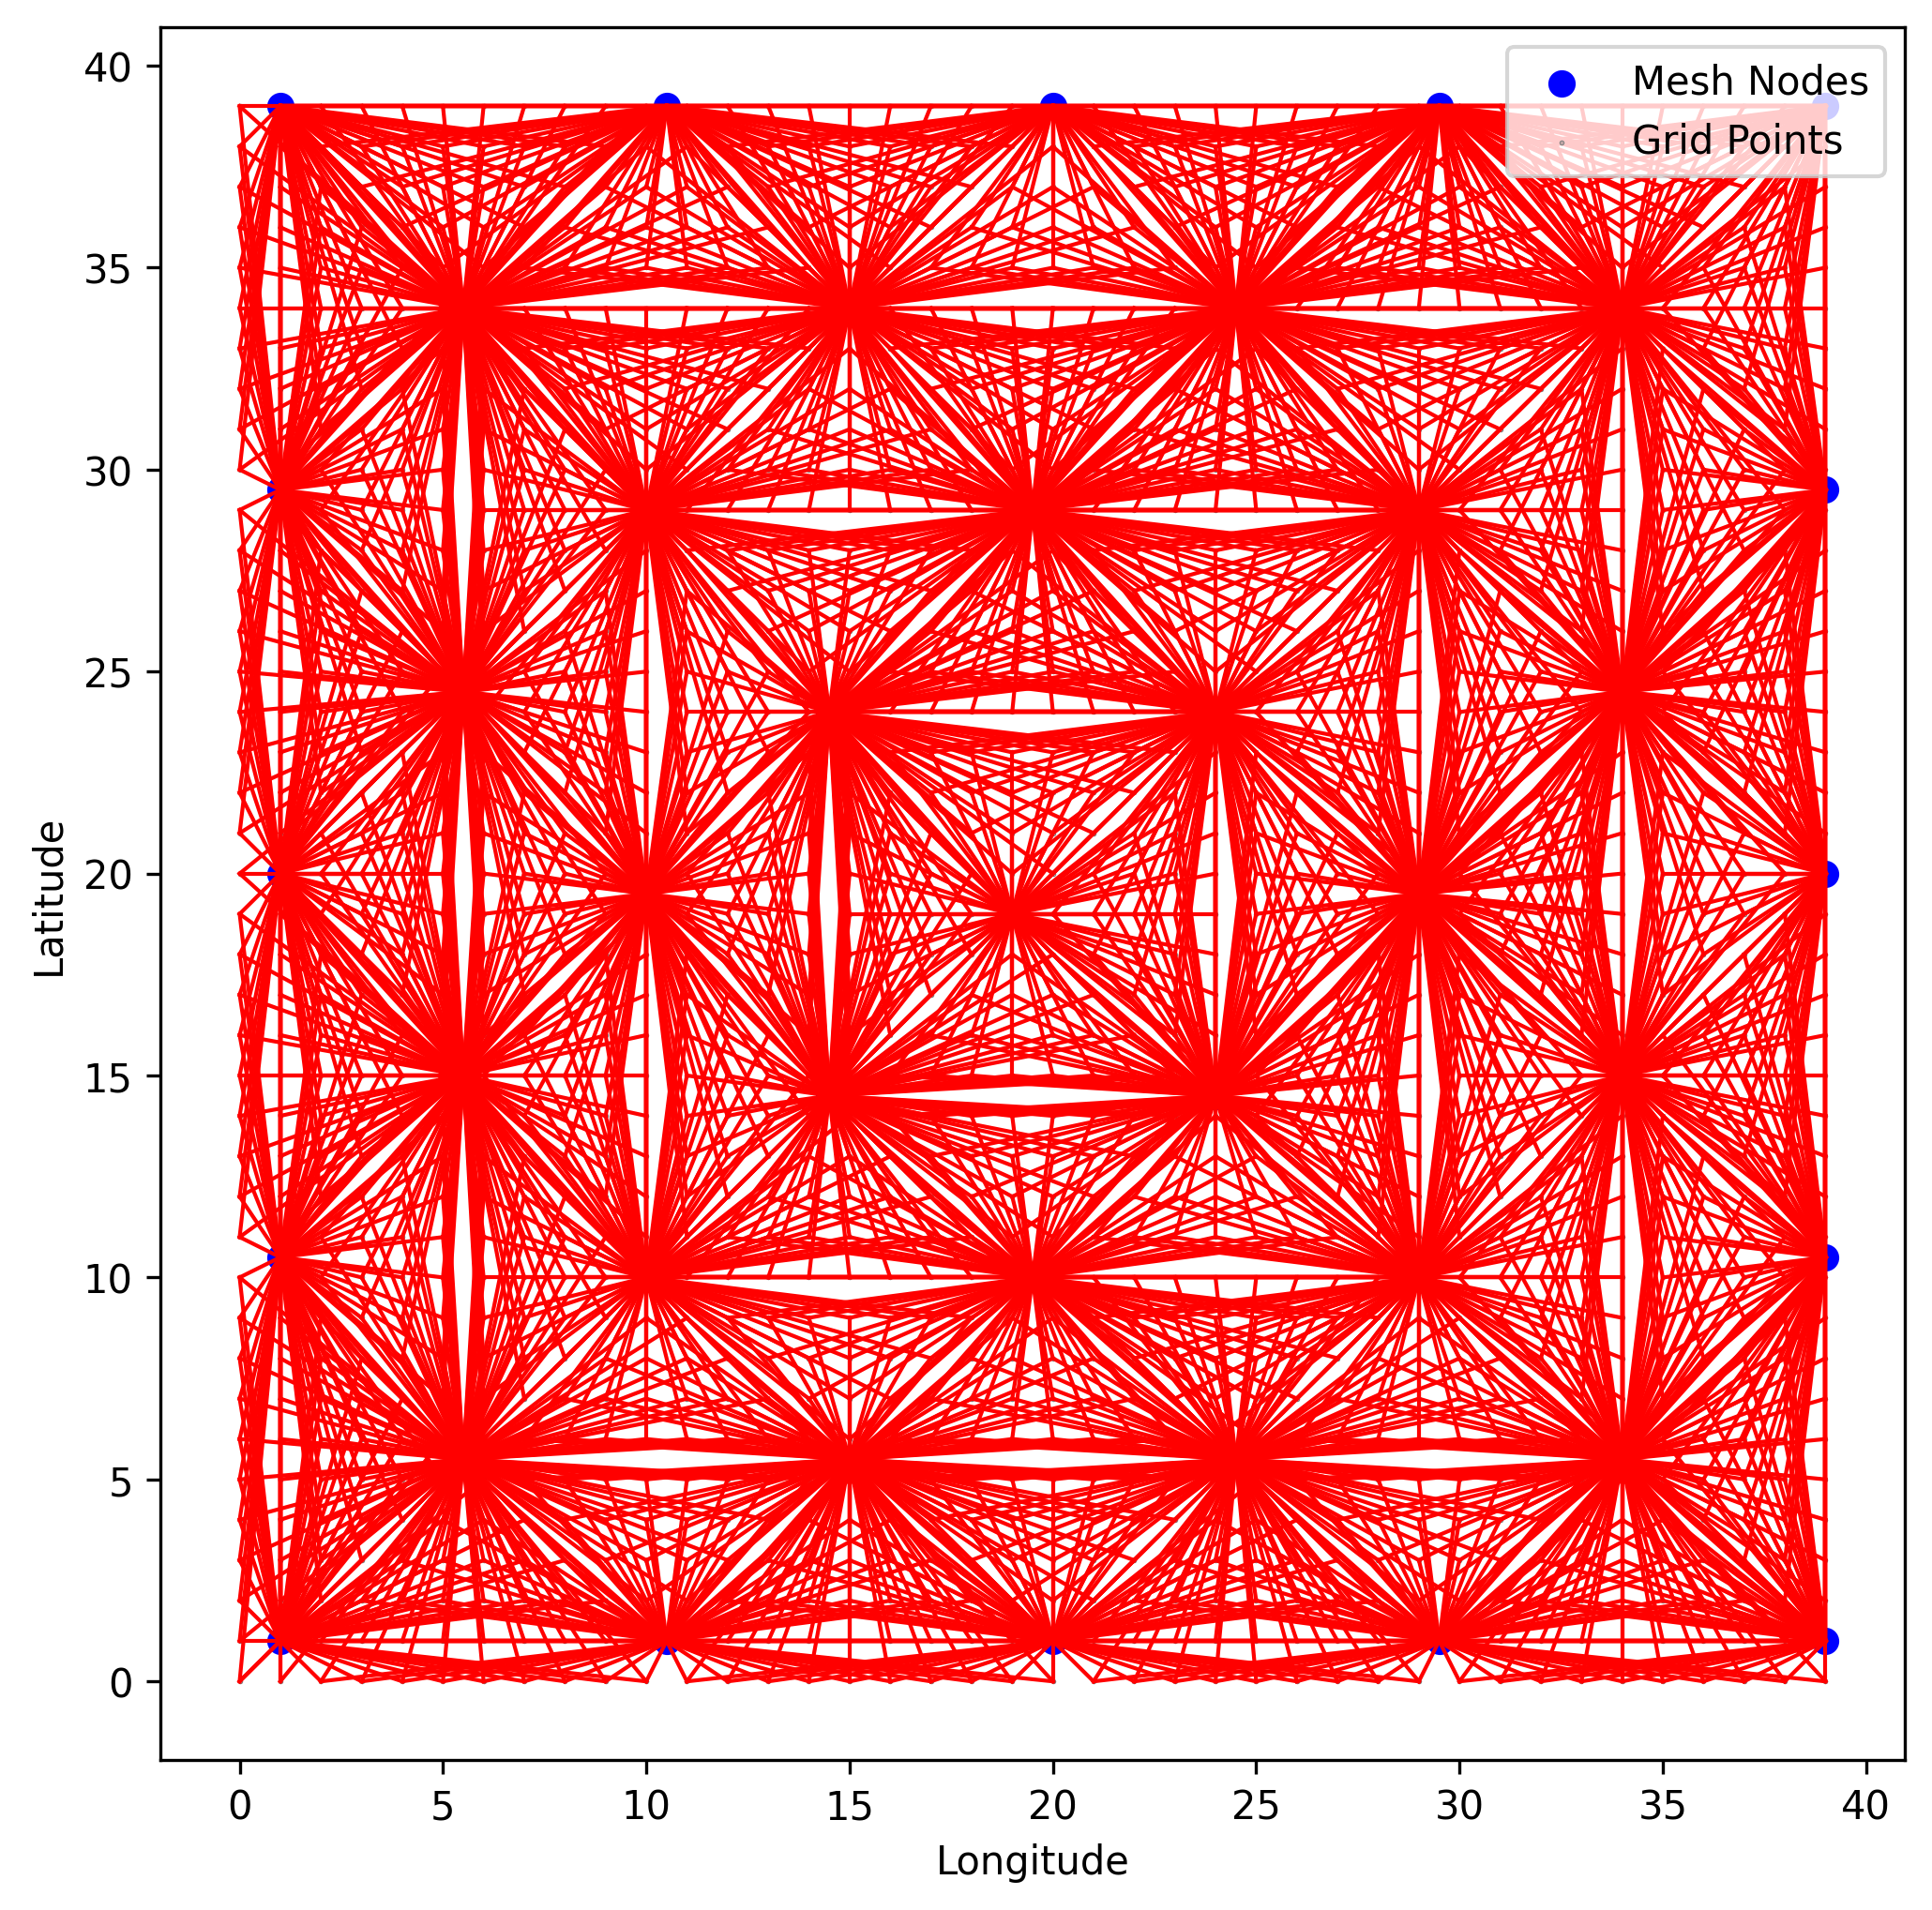

In [18]:
plot_connectivity(N, meshes[-1], these_grid_indices, these_mesh_indices)

## Plotting the Mesh nodes on the WoFS domain. 

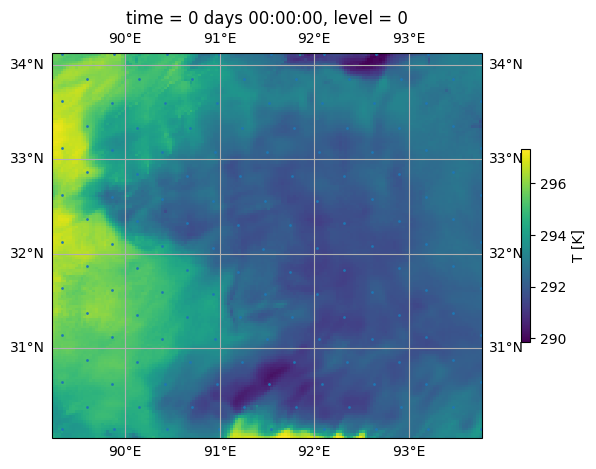

In [22]:
# Plot the MESH Nodes on the WoFS Domain 

# Create a figure and axis with a geographic projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines for context
ax.coastlines()

data_to_plot = dataset['T'].isel(time=0, level=0)

# Plot the data
data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(),  # Ensures data is projected correctly
                  x='lon', y='lat',  # Specifies the coordinate variables
                  cbar_kwargs={'shrink': 0.5})  # Adjust the colorbar size

ax.scatter(x=mesh_nodes_lon,y=mesh_nodes_lat, transform=ccrs.PlateCarree(), s=1)

# Add a gridlines and set the extent if needed
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
lon_min, lon_max = dataset['lon'].min().values, dataset['lon'].max().values
lat_min, lat_max = dataset['lat'].min().values, dataset['lat'].max().values

#ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  